# Data distribution

The main goal of this notebook is looking at the data distribution and it's scaling.

In [1]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid.inset_locator import inset_axes, zoomed_inset_axes

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['xtick.minor.pad'] = 15
plt.rcParams['xtick.major.pad'] = 15
plt.rcParams['ytick.minor.pad'] = 15
plt.rcParams['ytick.major.pad'] = 15
plt.rcParams['figure.constrained_layout.use'] = False

C:\Users\sapoz\AppData\Local\Temp/ipykernel_24108/3902144711.py:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes, zoomed_inset_axes


## Manna model

0it [00:00, ?it/s]

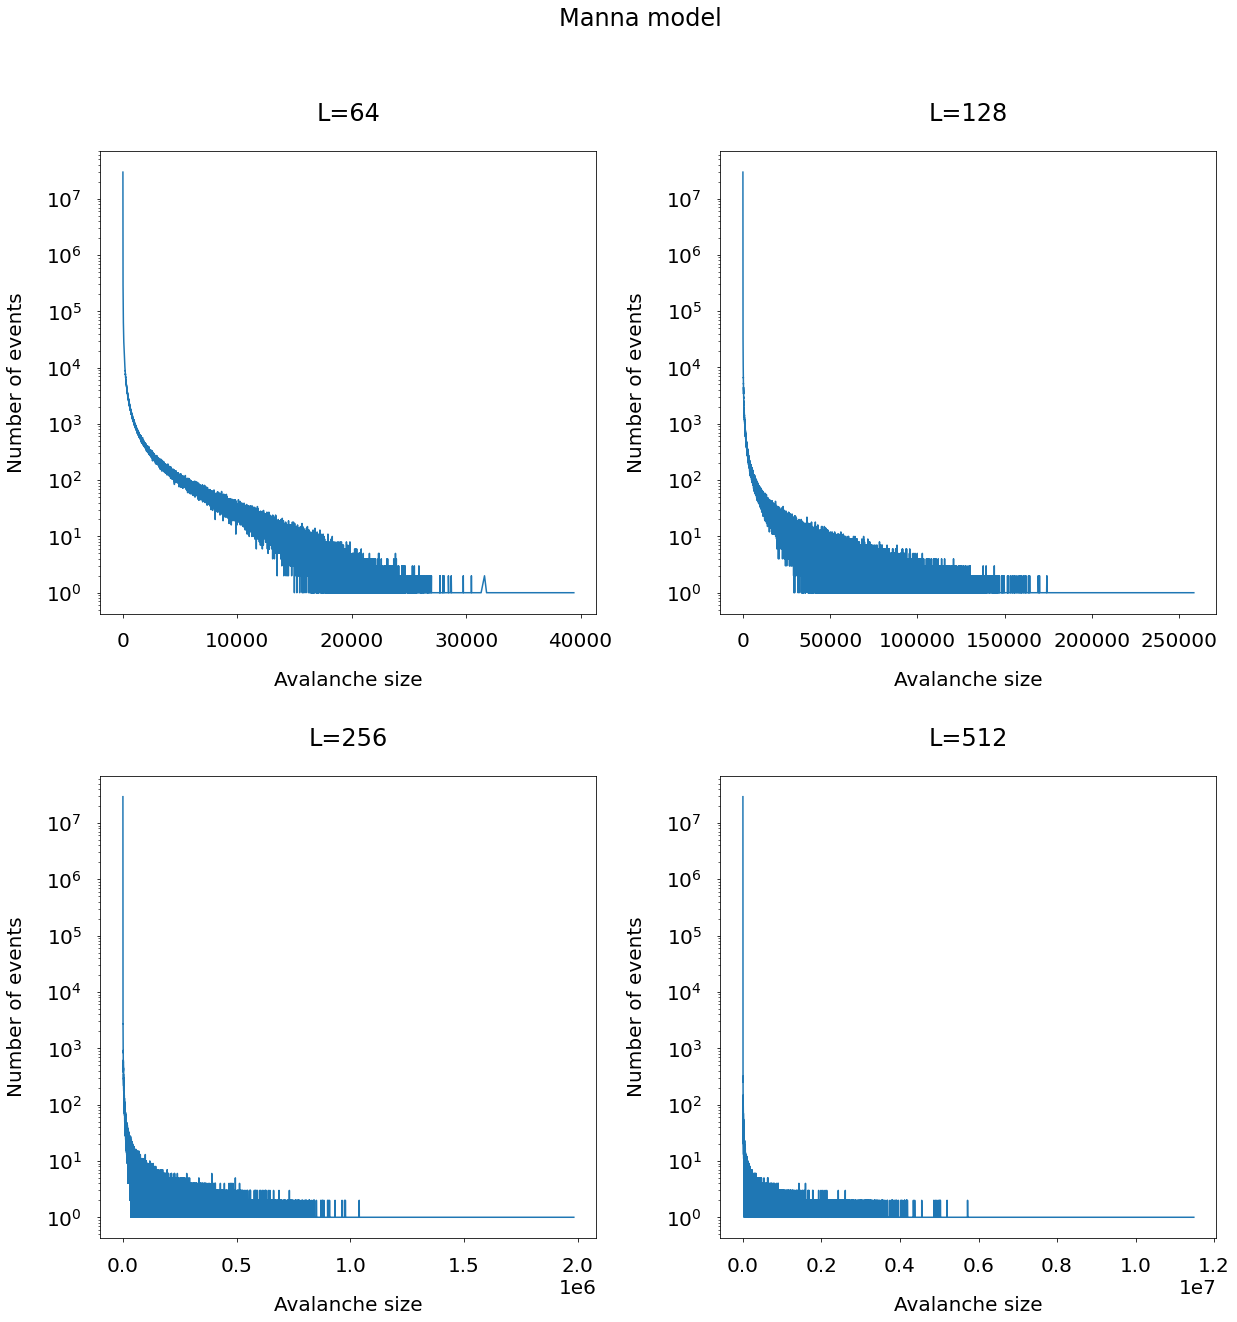

In [2]:
rand = {}

fig, _ = plt.subplots(2,2,figsize=(20,20))
fig.subplots_adjust(hspace=0.35, wspace=0.25)

for i, L in tqdm(enumerate([64, 128, 256, 512])):
    with open(f'../data/distribution/train_{L}_rand.out') as f:
        plt.subplot(2, 2, i+1)
        rand[L] = {}
        for line in f:
            size, count = list(map(int, line.split()))
            rand[L][size] = count
        plt.plot(rand[L].keys(), rand[L].values(), label=L)
        plt.yscale("log")
        plt.xlabel("Avalanche size")
        plt.ylabel("Number of events")
        plt.title(f"L={L}")

plt.suptitle("Manna model")

plt.show()

0it [00:00, ?it/s]

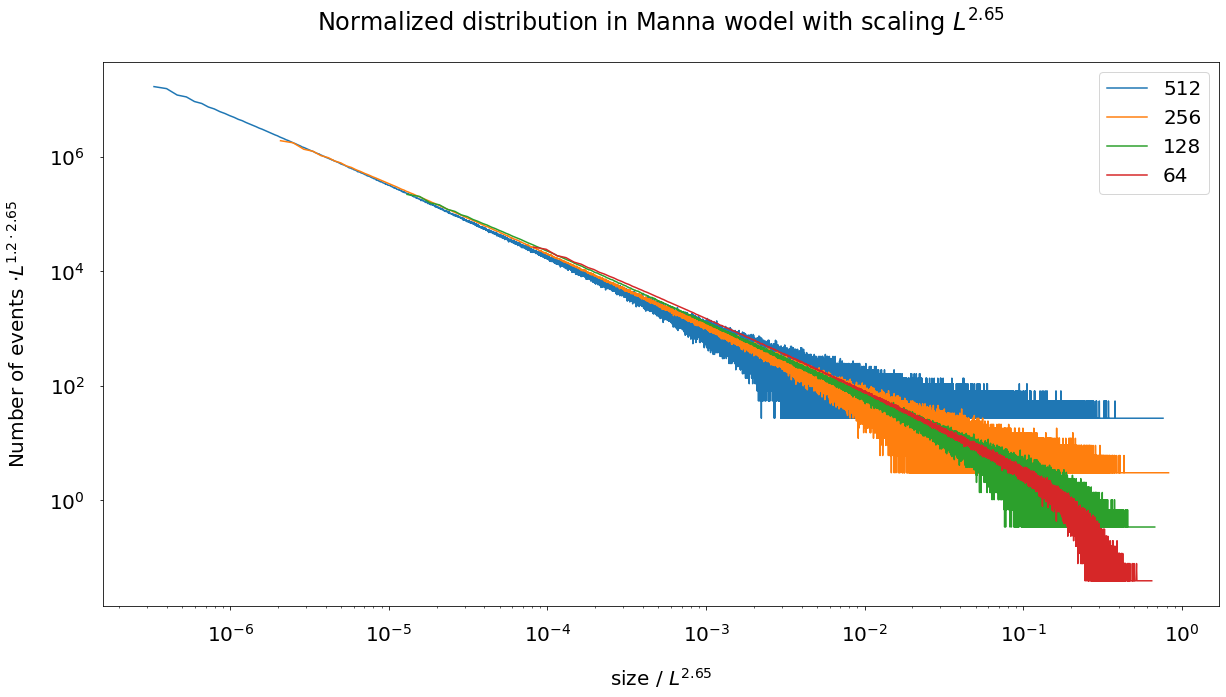

In [3]:
gamma = 2.65

for i, L in tqdm(enumerate(reversed([64, 128, 256, 512]))):
    sizes = np.array(list(rand[L].keys())[5:])
    count = np.array(list(rand[L].values())[5:])
    count = count / count.sum()
    plt.plot(sizes / L**gamma, count * L**(gamma * 1.20), label=L)
plt.title("Normalized distribution in Manna wodel with scaling $L^{" + str(gamma) + "}$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("size / $L^{" + str(gamma) + "}$")
plt.ylabel("Number of events $\cdot L^{1.2 \cdot " + str(gamma) + "}$")
plt.show()

In [4]:
def mfr(data, smax, smin, gap=1.2):
    lgap = np.log10(gap)
    lgsmax = np.log(smax) / np.log(10)
    lgsmin = np.log(smin) / np.log(10)
    num_of_size_arr = int(np.floor((lgsmax-lgsmin)/lgap))+1 #array length
    
    x = np.array([10 ** (lgsmin + lgap*(i+0.5)) for i in range(num_of_size_arr)])
    q = [0 for _ in range(num_of_size_arr)]
    s_out_of_arr = 0
    num_of_lines = 0
    for size, count in data.items():
        if size == 0:
            s_out_of_arr += count
            continue
        ind = int(np.floor((np.log10(size) - lgsmin) / lgap))
        if ind >= 0 and ind < num_of_size_arr:
            q[ind] += count
        else:
            s_out_of_arr += count

    q_int = np.array(q)
    total_event_num = q_int.sum() + s_out_of_arr

    q_sum = sum(q)
    return x, q_int, q_sum

In [5]:
def plot_distribution(all_data, gamma=None, title=False, yscale=None, y_str = None, xlim=[1e-7, 1e+0], innerxlim=[1e-7,1e+0], innerylim=[1e-1, 1e+1]):
    fig, ax = plt.subplots(1, 1)
    
    for i, L in tqdm(enumerate(reversed([64, 128, 256, 512]))):
        bins, count, total_count = mfr(all_data[L], 1e7, 5)
        count = count / total_count
        if gamma is None:
            ax.plot(bins, count, label=L)
        else:
            ax.plot(bins / L**gamma, count * L**(gamma * yscale), label=L)
    
    if gamma is not None:
        inner = inset_axes(parent_axes=ax,
                           width="65%",
                           height="50%",
                           loc=3,
                           borderpad=4)

        for i, L in tqdm(enumerate(reversed([64, 128, 256, 512]))):
            bins, count, total_count = mfr(all_data[L], 1e7, 5)
            count = count / total_count
            if gamma is None:
                inner.plot(bins, count, label=L)
            else:
                inner.plot(bins / L**gamma, count * L**(gamma * yscale), label=L)
                
    if gamma is None:
        if title:
            ax.set_title("Распределения событий в модели Манна")
        ax.set_xlabel("Размер события")
        ax.set_ylabel("Вероятность события")
    else:
        if title:
            ax.set_title("Отнормированное распределение событий по $L^{" + str(gamma) + "}$ в модели Манна")
        ax.set_xlabel("Размер события / $L^{" + str(gamma) + "}$")
        ax.set_ylabel("Вероятность события $\cdot L^{" + str(gamma) + r" \cdot " + y_str + "}$")
        ax.set_xlim(xlim)
        
    ax.set_yscale("log")
    ax.set_xscale("log")
    #ax.legend(loc=1)
    
    if gamma is not None:
        inner.set_yscale("log")
        inner.set_xscale("log")
        inner.set_xlim(innerxlim)
        inner.set_ylim(innerylim)
    
    plt.show()

0it [00:00, ?it/s]

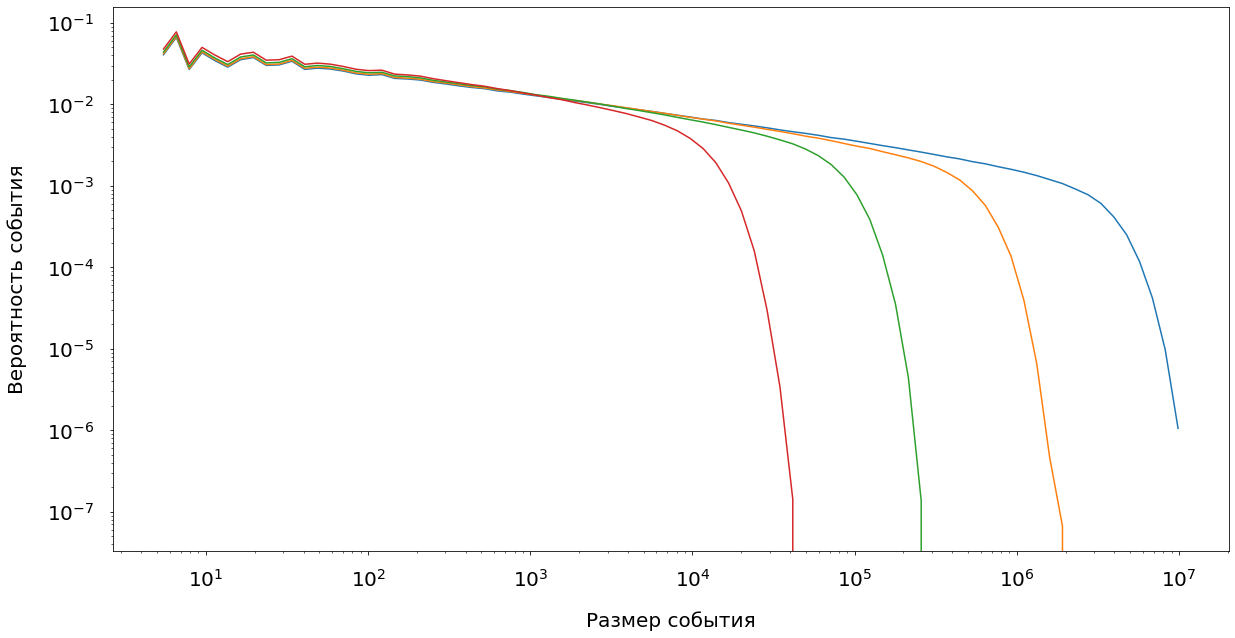

In [6]:
plot_distribution(rand, None)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

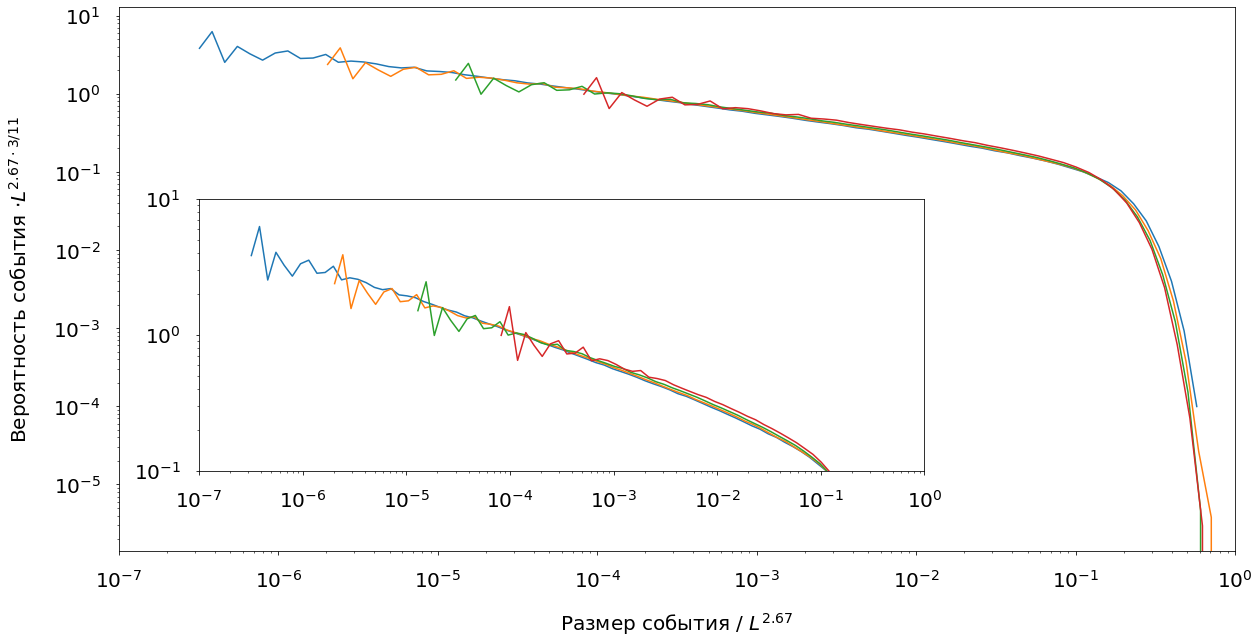

In [7]:
gamma = 2.67
plot_distribution(rand, gamma, False, 3./11, "3/11")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

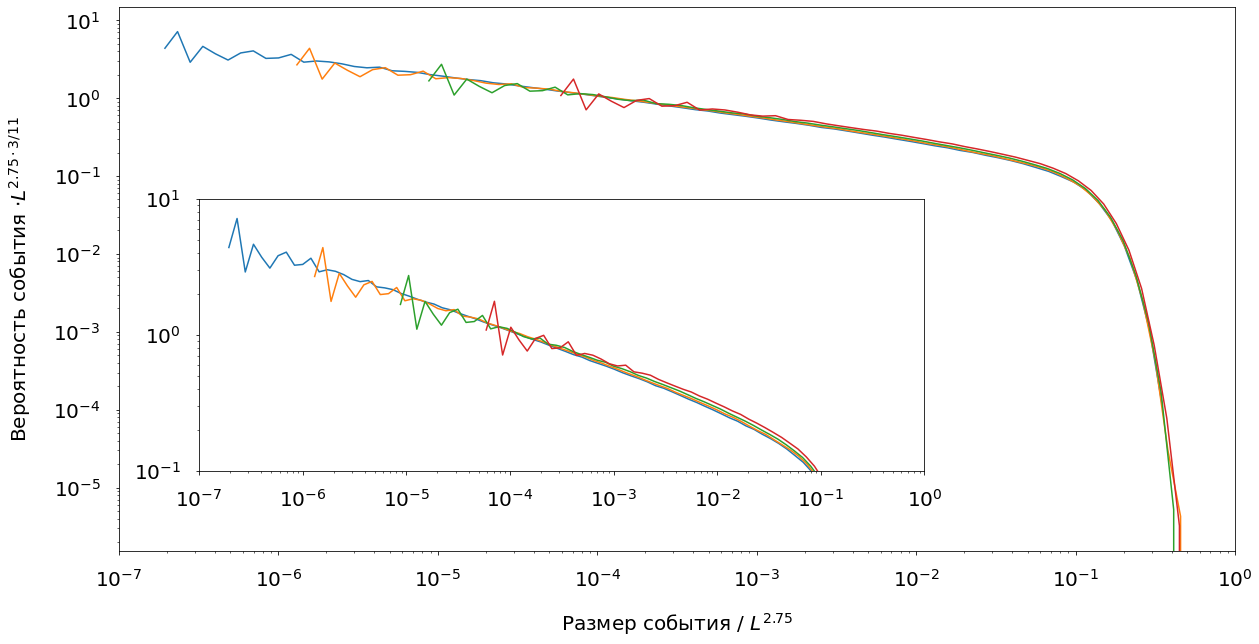

In [8]:
gamma = 2.75
plot_distribution(rand, gamma, False, 3./11, "3/11")

# BTW model

0it [00:00, ?it/s]

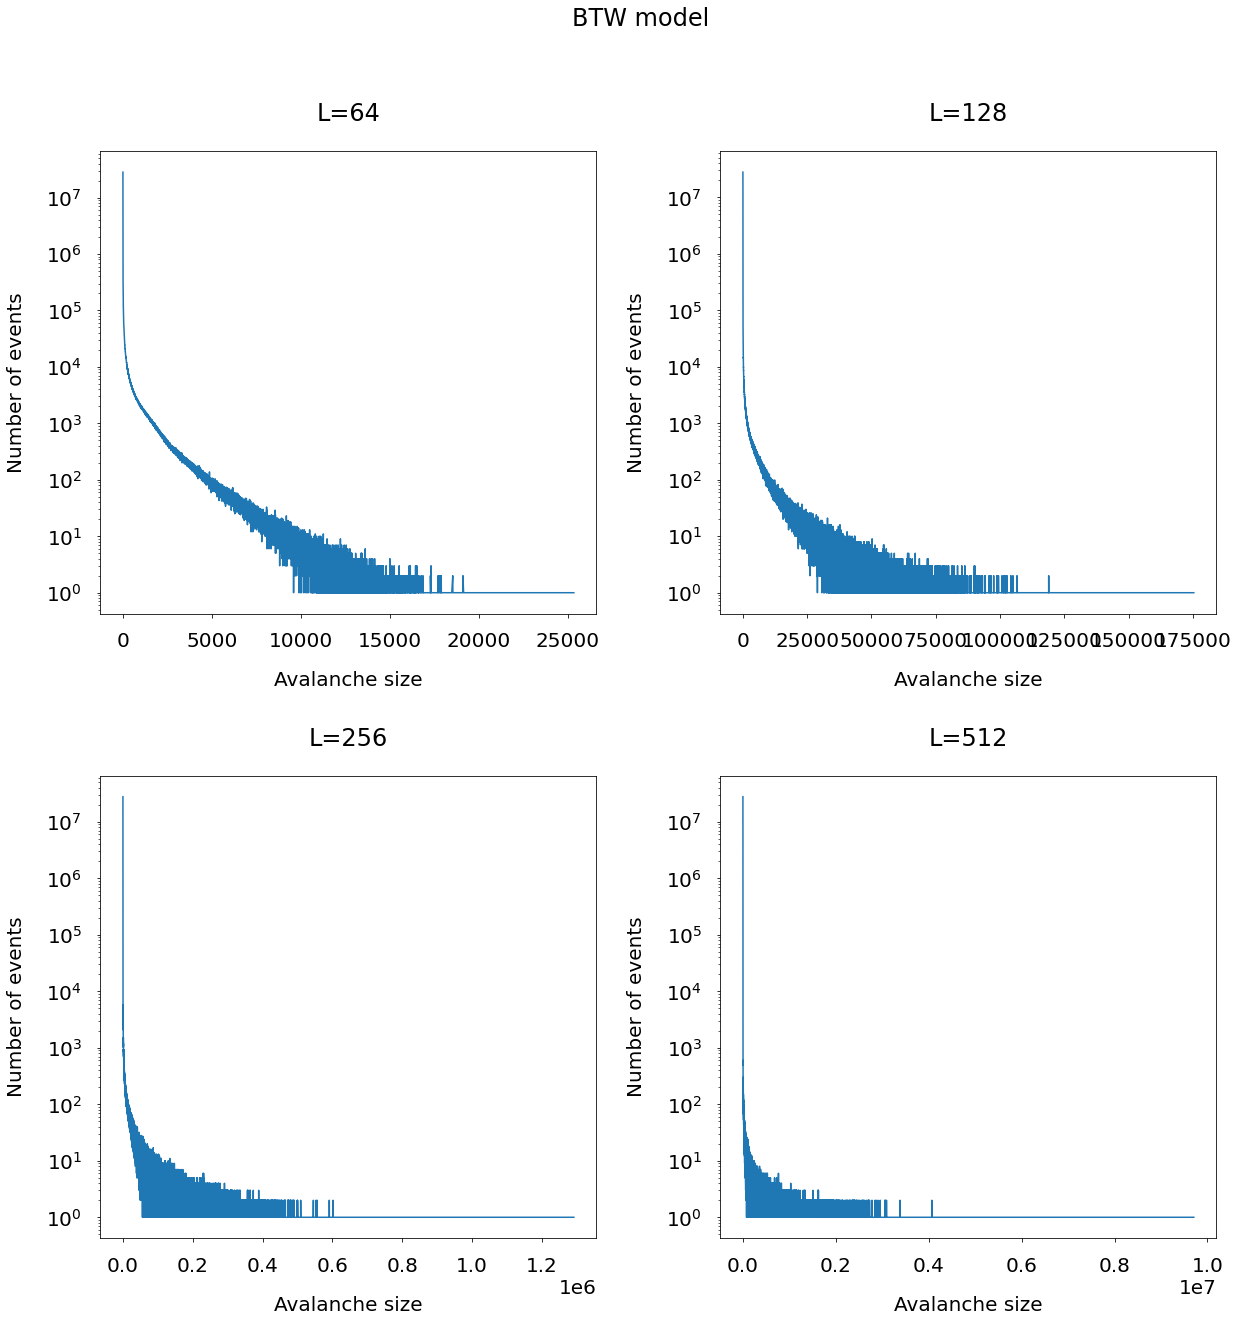

In [9]:
determ = {}

fig, _ = plt.subplots(2,2,figsize=(20,20))
fig.subplots_adjust(hspace=0.35, wspace=0.25)

for i, L in tqdm(enumerate([64, 128, 256, 512])):
    with open(f'../data/distribution/train_{L}_determ.out') as f:
        plt.subplot(2, 2, i+1)
        determ[L] = {}
        for line in f:
            size, count = list(map(int, line.split()))
            determ[L][size] = count
        plt.plot(determ[L].keys(), determ[L].values(), label=L)
        plt.yscale("log")
        #plt.legend()
        plt.xlabel("Avalanche size")
        plt.ylabel("Number of events")
        plt.title(f"L={L}")

plt.suptitle("BTW model")

plt.show()

0it [00:00, ?it/s]

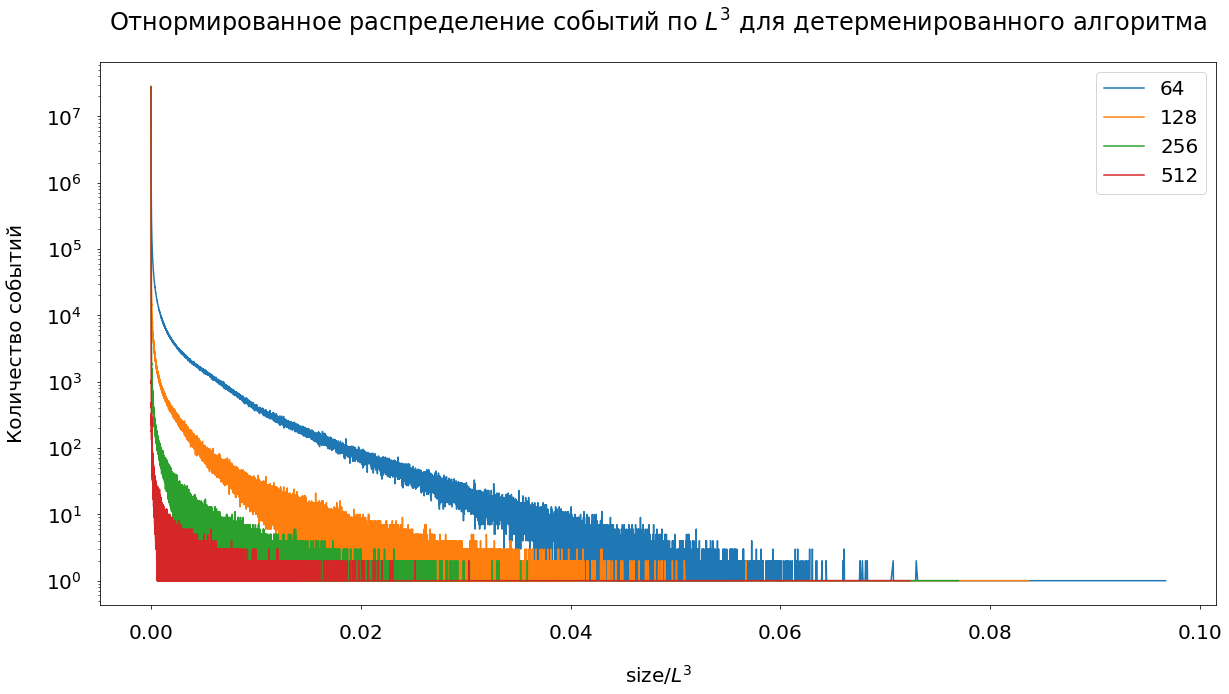

In [10]:
for i, L in tqdm(enumerate([64, 128, 256, 512])):
    sizes = np.array(list(determ[L].keys()))
    plt.plot(sizes / L**3, determ[L].values(), label=L)
plt.title("Отнормированное распределение событий по $L^{3}$ для детерменированного алгоритма")
plt.yscale("log")
#plt.xscale("log")
plt.legend()
plt.xlabel("size/$L^3$")
plt.ylabel("Количество событий")
plt.show()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

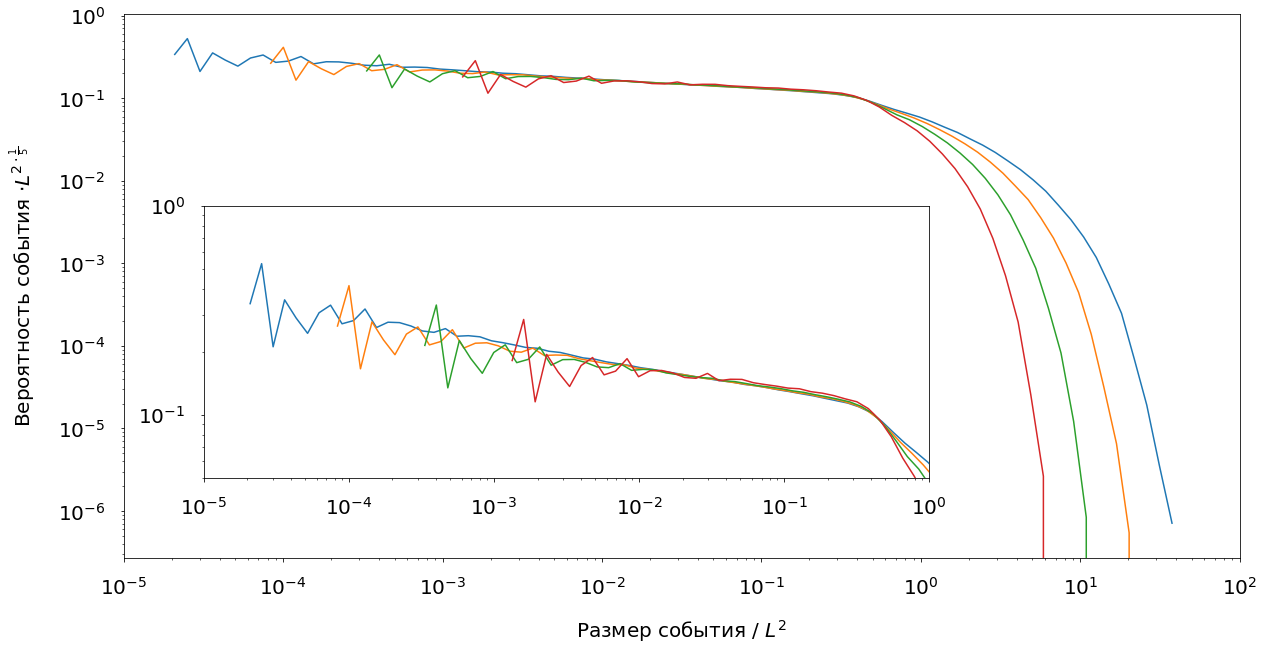

In [11]:
plot_distribution(determ, 2, False, 0.2, r"\frac{1}{5}", xlim=[1e-5, 1e+2], innerxlim=[1e-5, 1e+0], innerylim=[5e-2,1e+0])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

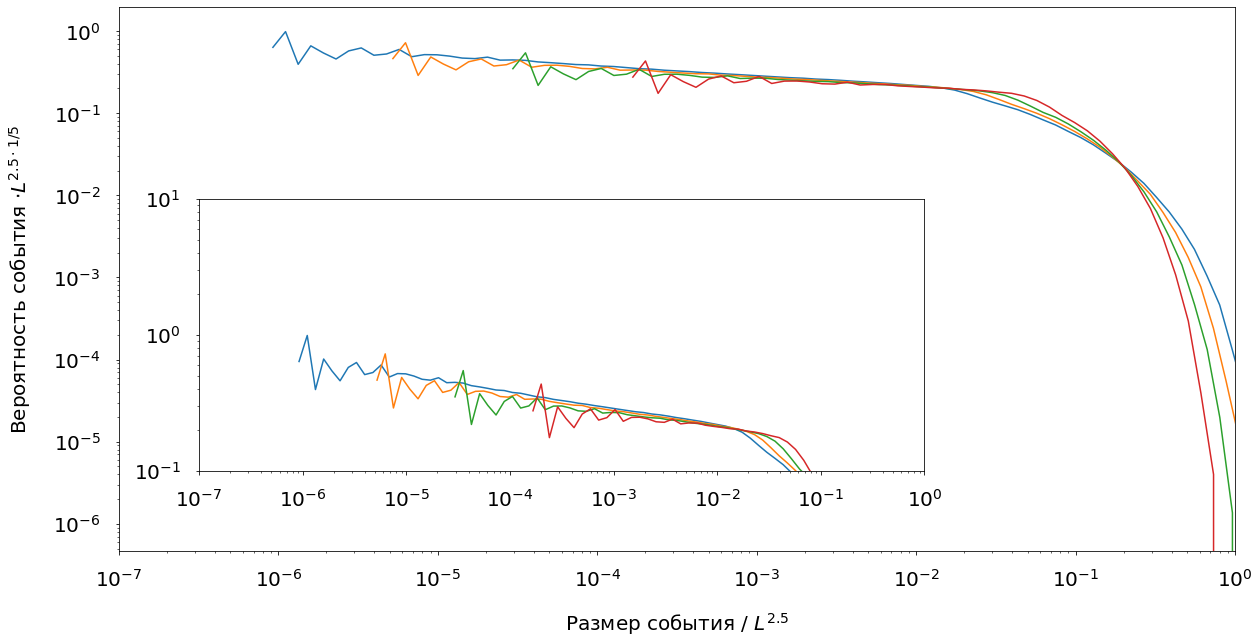

In [12]:
plot_distribution(determ, 2.5, False, 0.2, "1/5")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

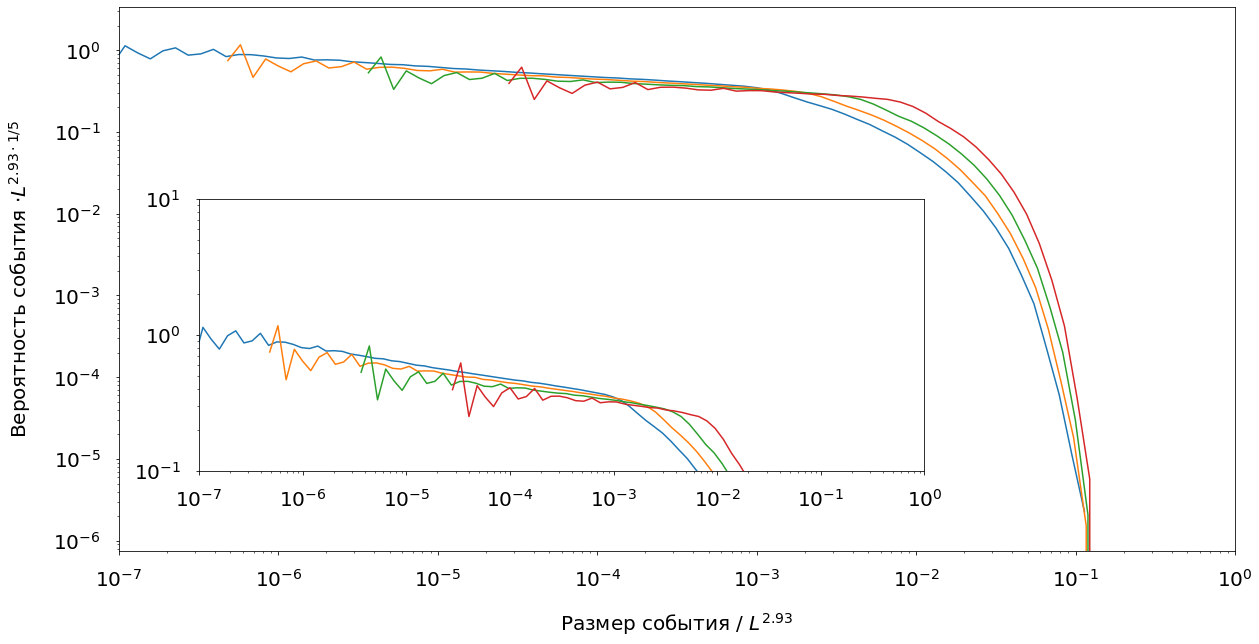

In [14]:
plot_distribution(determ, 2.93, False, 0.2, "1/5")